Assigment 5 WORD2VEC
-----


In [1]:
#all imports
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import subprocess
import time
from datetime import datetime, timedelta

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)


Found and verified text8.zip


In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


We can see a part of the text

In [4]:
part_of_the_text =  words[0:100] 
for i in part_of_the_text:
    print(i, end= ' ')

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing 

In [5]:
#pegamos a estrutuda de dados Counter da biblioteca
#collections para ordenar o texto numa lista cujos
#elementos são (palavra, # de ocorencias). Nesse caso
#queremos as 10 palavras que mais ocorrem

collections.Counter(part_of_the_text).most_common(10)
#The Counter class itself is a dictionary subclass 
#with no restrictions on its keys and values. 
#The values are intended to be numbers representing counts, 
#but you could store anything in the value field.
#The most_common() method requires only that the values be orderable.


[('the', 9),
 ('a', 4),
 ('of', 4),
 ('used', 3),
 ('as', 3),
 ('anarchism', 3),
 ('is', 3),
 ('that', 2),
 ('and', 2),
 ('term', 2)]

In [17]:
#escolhemos um tamanho V para o vocabulario
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  
  #pegamos as V-1 palavras do texto mais utilizadas
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  
  #atribuimos para cada uma das V-1 palavras mais usadas
  #um numero unico
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)

  #reconstruimos o texto como uma lista de indices
  #para cada palavra w, se w in dictionary, seu indice eh o
  #mesmo que o do dicionario, caso contratio seu indice 
  #eh 0 para 'UNK'.
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  
  #reverse_dict é o dicionario com o mesmo conteudo que 
  #dictionary mas invertido, i.e, se palavra:index in dictionary,
  #entao index:palavra in reverse_dictionary
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

Agora podemos pegar o texto de entrada e retornar certos dados

In [35]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

NameError: name 'words' is not defined

Function to generate a training batch for the skip-gram model.
----

Dado um batch_size = n, num_skips = k e skip_window = s, essa funcao vai criar n exemplos para o treinamento. Para cada palavra w do texto ela vai usar essa palavra  k vezes do seguinte modo, abrindo uma janela de tamanho s em torno  da palavra (tanto para esquerda quanto para a direita) ela vai aleatoriamente escolher uma palavra w* para ser o label de w. 


In [57]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels



Suponha que nosso corpus fosse apenas uma sentenca:

In [97]:
print([reverse_dictionary[di] for di in data[10:29]])


['early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution']


Podemos gerar o seguinte conjunto de treinamento de tamanho 25, passando por cada palavra apenas uma vez e tomando uma janela de tamanho 2

In [99]:
data_index = 0
batch, labels = generate_batch(batch_size=25, num_skips=1, skip_window=2)
print('\nnum_skips = %d and skip_window = %d:' % (1, 2))
l =[reverse_dictionary[bi] for bi in batch]
r =[reverse_dictionary[li] for li in labels.reshape(25)]
lr = zip(l,r)
print('\n')
for i in lr:
    print('context word = {0} , output word = {1}'.format(i[0],i[1]))


num_skips = 1 and skip_window = 2:


context word = as , output word = term
context word = a , output word = as
context word = term , output word = a
context word = of , output word = term
context word = abuse , output word = of
context word = first , output word = abuse
context word = used , output word = first
context word = against , output word = first
context word = early , output word = class
context word = working , output word = radicals
context word = class , output word = radicals
context word = radicals , output word = working
context word = including , output word = the
context word = the , output word = of
context word = diggers , output word = the
context word = of , output word = the
context word = the , output word = english
context word = english , output word = and
context word = revolution , output word = english
context word = and , output word = english
context word = the , output word = sans
context word = sans , output word = the
context word = UNK , output word

Construindo o Grafo em tensorflow:
-----

In [105]:
#training parameters

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 
num_skips = 2 

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

print([reverse_dictionary[i] for i in valid_examples])

['are', 'most', 'one', 'more', 'an', 'to', 'would', 'seven', 'all', 'he', 'had', 'first', 'the', 'american', 's', 'its']


In [106]:
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  #Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size],name= 'X')
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1],name= 'Y')
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32, name ='valid_dataset')
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embedding_matrix')
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)), name='softmax_weights')
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name ='softmax_biases')

  #histogram summaries for weights
  tf.histogram_summary('Embeddings',embeddings)
  tf.histogram_summary('Softmax_weights',softmax_weights)
  
  # Model.
  #This function is used to perform parallel
  #lookups on the list of tensors in params. 
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  #Compute the softmax loss, using a sample of the negative labels each time.
  #---tf.nn.sampled_softmax_loss:
  #Computes and returns the sampled softmax training loss.
  #This is a faster way to train a softmax classifier over a huge number of classes.
  #This operation is for training only. It is generally an underestimate of the full softmax loss. 
  
  with tf.name_scope('loss'): 
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                 train_labels, num_sampled, vocabulary_size))
    tf.scalar_summary(loss.op.name,loss) #write loss to log

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  with tf.name_scope('training'):
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [ ]:
#direction for the writer to log
log_basedir = 'logs'
run_label = time.strftime('%d-%m-%Y_%H-%M-%S') #e.g. 12-11-2016_18-20-45
log_path = os.path.join(log_basedir,run_label)


num_steps = 100001
initial_time = time.time()

with tf.Session(graph=graph) as session:
  summary_writer = tf.train.SummaryWriter(log_path, session.graph) 
  all_summaries = tf.merge_all_summaries() 
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):

    #setting up the parameters
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    #we are going to run the session and count the duration of the running 
    start_time = time.time()
    _, l,summary = session.run([optimizer, loss,all_summaries], feed_dict=feed_dict)
    duration = time.time() - start_time

    #writing the log
    summary_writer.add_summary(summary,step)
    summary_writer.flush()

    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      print('Duration: %.3f sec' % duration)
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
      print('Duration: %.3f sec' % duration)
  final_embeddings = normalized_embeddings.eval()

#subprocess.call(['speech-dispatcher'])        
#subprocess.call(['spd-say', '"over"'])
general_duration = time.time() - initial_time
sec = timedelta(seconds=int(general_duration))
d_time = datetime(1,1,1) + sec
print(' ')
print('The duration of the whole training with % s steps is %.2f seconds,'\
      % (num_steps,general_duration))
print("which is equal to:  %d:%d:%d:%d" % (d_time.day-1, d_time.hour, d_time.minute, d_time.second), end='')
print(" (DAYS:HOURS:MIN:SEC)")
print(' ')
print(log_path)
#!tensorboard --logdir=!!!copy log_path here!!!

Initialized
Average loss at step 0: 7.746510
Duration: 0.285 sec
Nearest to are: hamad, poole, wildly, degenerative, ornithologists, ebay, msn, kt,
Nearest to most: rankings, diddy, modus, vulnerable, shrouded, stipend, frankenheimer, excommunicated,
Nearest to one: salazar, sprayed, pantomime, marcus, argon, chagas, starry, modernists,
Nearest to more: wiesbaden, affected, thelma, emigrated, peng, chaos, fathers, honored,
Nearest to an: condiments, planted, camcorder, pickled, blend, gba, subjectivity, eratosthenes,
Nearest to to: disappears, notches, devils, reins, archtop, incidence, unearthed, tertius,
Nearest to would: genera, squadron, semiology, marcos, ruppert, hanukkah, verde, tremble,
Nearest to seven: samurai, miggins, assoc, lancet, rad, exception, innermost, sigma,
Nearest to all: evaporating, galvani, bale, ssp, transcriptions, garp, leaders, coleridge,
Nearest to he: abingdon, certify, verse, medications, dylan, thoracic, assessing, scanned,
Nearest to had: safari, arizo

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

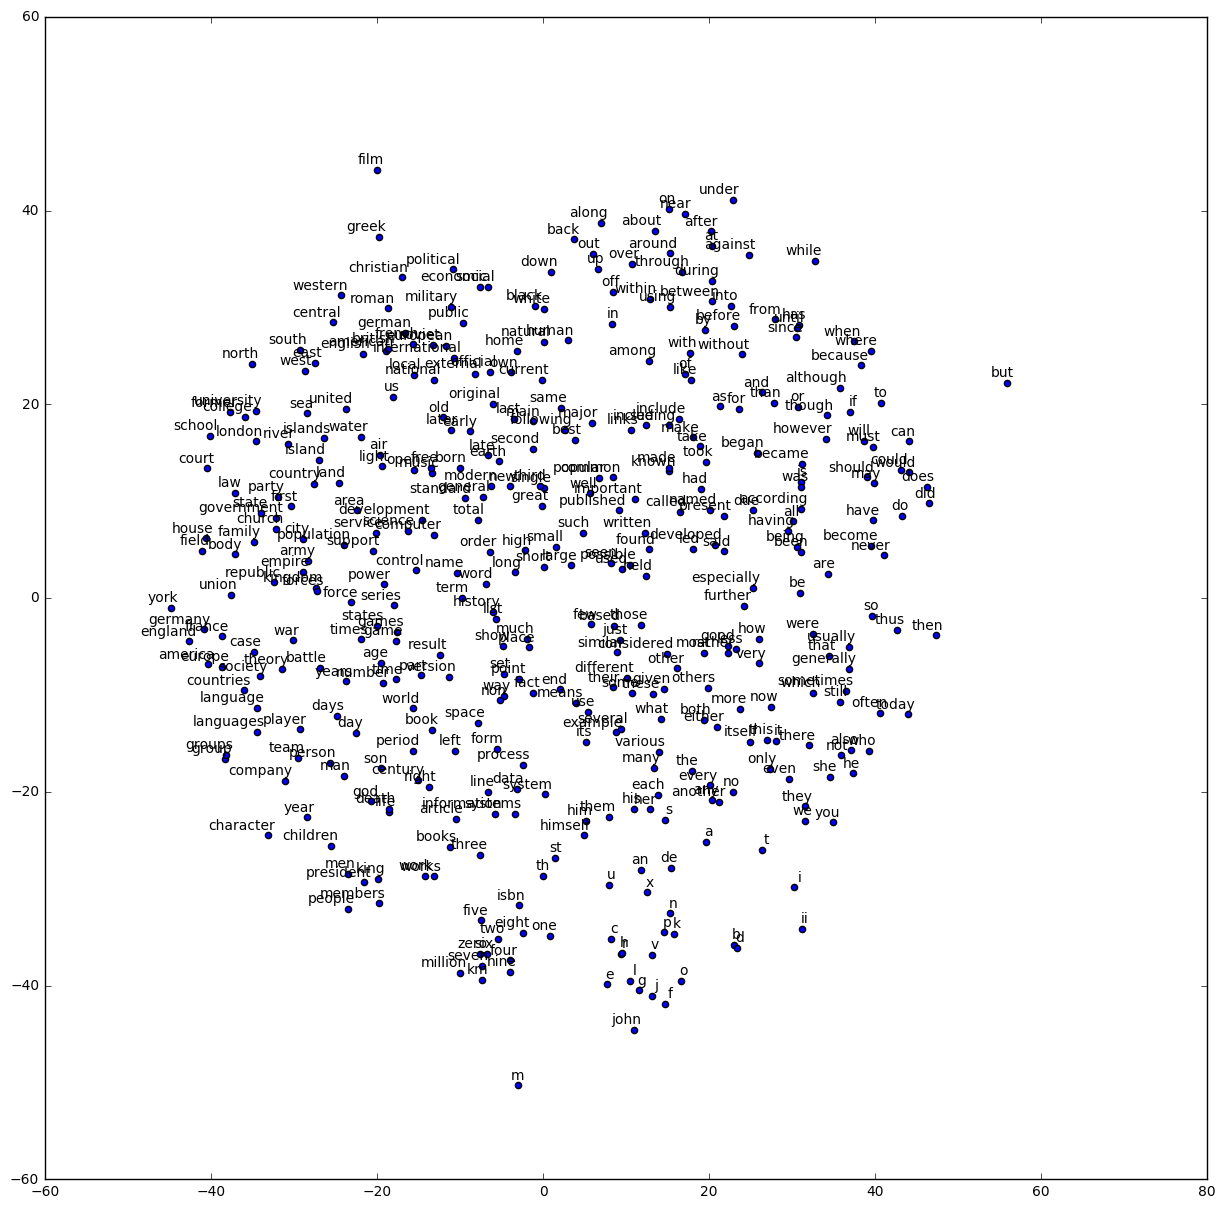

In [13]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)